# New Section

In [ ]:
!pip install pafy youtube-dl moviepy
!pip install imageio==2.4.1
!pip install imageio-ffmpeg/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 33.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for imageio: filename=imageio-2.4.1-py3-none-any.whl size=3303886 sha256=0ebe42d1c5e001db4f0c595d49ce38dbcc75b9d37760f3084d085fd98d3f396a
  Stored in directory: /root/.cache/pip/wheels/96/5d/ce/bdbdb04744dac03906336eb0d01ff1e222061d3419c55c55f9
Successfully built imageio
  Attempting uninstall: imageio
    Found existing installation: imageio 2.25.1
    Uninstalling imageio-2.25.1:
      Successfully uninstalled imageio-2.25.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
moviepy 1.0.3 requires imageio<3.0,>=2.5; python_version >= "3.4", but you have imageio 2.4.1 which is incompatible.
ERROR: Invalid requirement: 'imageio-ffmpeg/'
Hint: It looks l

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import math
import pafy
import random
import numpy as np
import datetime as dt
import tensorflow as tf
import ast
import re
from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import regularizers
from sklearn.svm import SVC
import pickle
import gc


In [ ]:
import tensorflow as tf
tf.config.list_physical_devices()
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [ ]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

root_dir = '/content/drive/MyDrive/HAR2/'
# root_dir = '/content/drive/MyDrive/'
os.chdir(root_dir)
contents = os.listdir(root_dir)
for item in contents:
#   pass
  print(item)

# PATH IF '/content/drive/MyDrive/HAR DATA/' THEN BELOW
folder_path = 'HARDATA'
contents = os.listdir(folder_path)
for item in contents:
    print(item ,end = ",")

HARDATA
subpath_features
smoke,hit,catch,jump,hug,shoot_gun,kiss,brush_hair,walk,chew,climb,climb_stairs,dive,draw_sword,dribble,drink,

In [ ]:
plt.figure(figsize = (20, 20))
all_classes_names = ['walk','brush_hair','catch','chew','climb','climb_stairs','dive','draw_sword','dribble','drink','eat','fall_floor','fencing','flic_flac','golf','handstand','hit','hug','jump','kick','kick_ball','kiss','laugh','pick','pullup','punch','push','pushup','ride_bike','ride_horse','shake_hands','shoot_bow','shoot_gun','sit','situp','smile','smoke','stand','swing_baseball','sword','sword_exercise','talk','throw','turn','wave','cartwheel','pour','run','shoot_ball','somersault','clap']


# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 30

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = "HARDATA"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = all_classes_names[0:10]

<Figure size 2000x2000 with 0 Axes>

In [ ]:
import pandas as pd

if not os.path.exists("subpath_features"):
    os.makedirs("subpath_features")


csv_path2 = os.path.join("subpath_features", "lables.npy")
csv_path3 = os.path.join("subpath_features", "paths.csv")

In [ ]:
#CLASSES_LIST = CLASSES_LIST[0:10]

labels = np.load(csv_path2)
labels = labels[0:2209]
one_hot_encoded_labels = to_categorical(labels)
print(one_hot_encoded_labels)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

In [ ]:
def create_cnn_bilstm_model():
  cnn = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
  # Freeze the CNN layers
  for layer in cnn.layers:
    layer.trainable = False
  # Define the model architecture
  model = Sequential()
  model.add(TimeDistributed(cnn, input_shape=(SEQUENCE_LENGTH,IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
  model.add(TimeDistributed(Flatten()))
  model.add(Bidirectional(LSTM(64, return_sequences=True)))
  model.add(Dropout(0.5))
  model.add(Bidirectional(LSTM(32)))
  model.add(Dense(len(CLASSES_LIST), activation='softmax'))
  model.summary()

    # Return the constructed convlstm model.
  return model


# Compile the model
check = 0

In [ ]:
model = create_cnn_bilstm_model()
check = 0

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 2, 2, 512)    14714688  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 2048)         0         
 tributed)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 30, 128)          1081856   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41

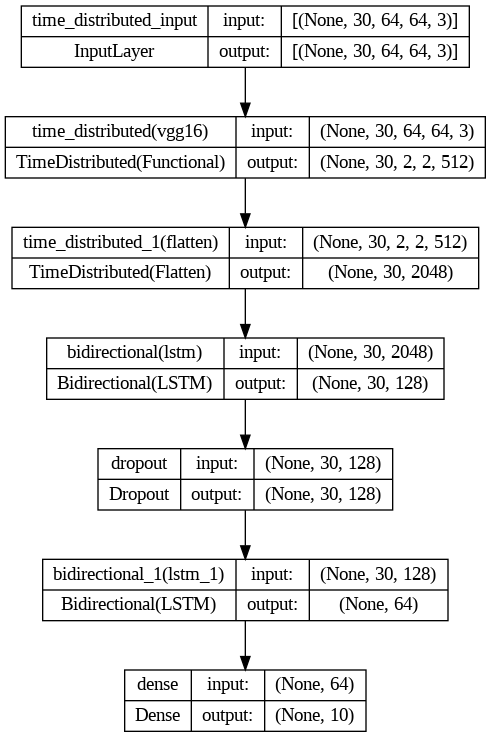

In [ ]:
plot_model(model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:

npypath = os.path.join("subpath_features",  f"features.npy")
k = 5 # number of folds
num_epochs = 10
batch_size = 32
histories=[]
scores = []

def loads() :
    features = np.load(npypath)
    # Create KFold object
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    x = kf.split(features)
    splits = list(x)
    with open('splits.pkl', 'wb') as f:
        pickle.dump(splits, f)
loads()



In [ ]:

try:
    with open('scores1.pkl', "rb") as file:
        scores = pickle.load(file)
        print("Exist")
except FileNotFoundError:
    scores = {}
    with open('scores1.pkl', 'wb') as b:
        pickle.dump(scores, b)
    print("new dict")


new dict


In [ ]:
splits = []
with open('splits.pkl', 'rb') as f:
    splits = pickle.load(f)
scores = {}
with open('scores1.pkl', 'rb') as f:
    scores = pickle.load(f)

intermediate_model = None
# Loop over the folds
kfold_value = 0
endKfold_value = kfold_value+1

model_num = check
im = kfold_value
for j, (train_indices, val_indices) in enumerate(splits[kfold_value:endKfold_value]):
    if im in scores :
        im = im + 1
        continue
    else :
        im = kfold_value
        batch_size = 32

        features = np.load(npypath)
        features = np.asarray(features)
        X_train, y_train = features[train_indices], one_hot_encoded_labels[train_indices]
        X_val, y_val = features[val_indices], one_hot_encoded_labels[val_indices]

        %reset_selective -f features
        gc.collect()

        model = create_cnn_bilstm_model();
        early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
        model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
        model_num = check
        check = check + 1

        LRCN_model_training_history = model.fit(x = X_train, y = y_train, epochs = 40, batch_size = 8 , validation_data=(X_val, y_val), callbacks = [early_stopping_callback])
        histories.append(LRCN_model_training_history)

        %reset_selective -f ^(X_)
        %reset_selective -f ^(y_)
        gc.collect()

        layer_output=model.get_layer(f'bidirectional_{(model_num*2)+3}').output
        model_num = check


        intermediate_model=tf.keras.models.Model(inputs=model.input,outputs=layer_output) #Intermediate model between Input Layer and Output Layer which we are concerned about

        features = np.load(npypath)
        features = np.asarray(features)
        fat_train, fat_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = seed_constant)
        %reset_selective -f features
        gc.collect()

        num_samples = fat_train.shape[0]
        num_batches = num_samples // batch_size
        X_train_batches = []
        start_idx = 0
        end_idx = 0
        for i in range(num_batches+1):
            start_idx = end_idx
            end_idx =  start_idx + batch_size
            if end_idx > num_samples:
                end_idx = num_samples
            batch = fat_train[start_idx:end_idx]
            X_train_batch = intermediate_model.predict(batch)
            X_train_batches.append(X_train_batch)
        X_train = np.concatenate(X_train_batches, axis=0)

        num_samples = fat_test.shape[0]
        num_batches = num_samples // batch_size
        X_test_batches = []
        start_idx = 0
        end_idx = 0
        for i in range(num_batches+1):
            start_idx = end_idx
            end_idx =  start_idx + batch_size
            if end_idx > num_samples:
                end_idx = num_samples
            batch = fat_test[start_idx:end_idx]
            X_test_batch = intermediate_model.predict(batch)
            X_test_batches.append(X_test_batch)
        X_test = np.concatenate(X_test_batches, axis=0)

        %reset_selective -f ^(fat_)
        %reset_selective -f ^(batch)
        gc.collect()

        # print([X_train.shape,X_test.shape])
        X_train = X_train.reshape(X_train.shape[0], -1)
        X_test = X_test.reshape(X_test.shape[0], -1)
        # print([X_train.shape,X_test.shape])

        # print([labels_train.shape,labels_test.shape])

        svm = SVC(kernel='linear', probability=True,C=1.0)
        svm.fit(X_train, np.where(labels_train==1)[1])

        %reset_selective -f X_train
        %reset_selective -f labels_train
        gc.collect()
        accuracy = svm.score(X_test, np.where(labels_test==1)[1])
        print("Accuracy:", accuracy)
        scores[im] = accuracy

        %reset_selective -f X_test
        %reset_selective -f labels_test
        gc.collect()
        # Save the model
        model.save(f'model_fold_{i+1}.h5')
        intermediate_model.save(f'intermediate_model_fold_{i+1}.h5')
        pickle.dump(svm,open(f'svm_{i+1}.pickle',"wb"))

        with open('scores1.pkl', 'wb') as b:
            pickle.dump(scores, b)

        # Reset the model weights for the next fold
        model.reset_states()

        im = im + 1

        %reset_selective -f model
        %reset_selective -f svm

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDis  (None, 30, 2, 2, 512)    14714688  
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 2048)         0         
 tributed)                                                       
                                                                 
 bidirectional_2 (Bidirectio  (None, 30, 128)          1081856   
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               41216     
 nal)                                                 

In [ ]:
# Calculate the average performance metric
with open('scores.pkl', 'rb') as f:
    scores = pickle.load(f)
#print(histories)
avg_metric = np.mean([scores[x] for x in scores])
print(f'Average validation accuracy: {avg_metric}')